File to plot the output groundwater levels of the 9 test cases as cross-sections with their layer thicknesses

In [2]:
# imports
import numpy as np
import pandas as pd
import geopandas as gpd
import fiona
import matplotlib as mpl
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import contextily as ctx
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask
from shapely.geometry import Point, LineString
import utm

from regional_K.cpt_functions import setup_grid, assign_elevation, get_groundwater_values

import warnings
warnings.filterwarnings('ignore')


In [3]:
points = setup_grid(geoplot='./geojson/alameda_city.geojson')


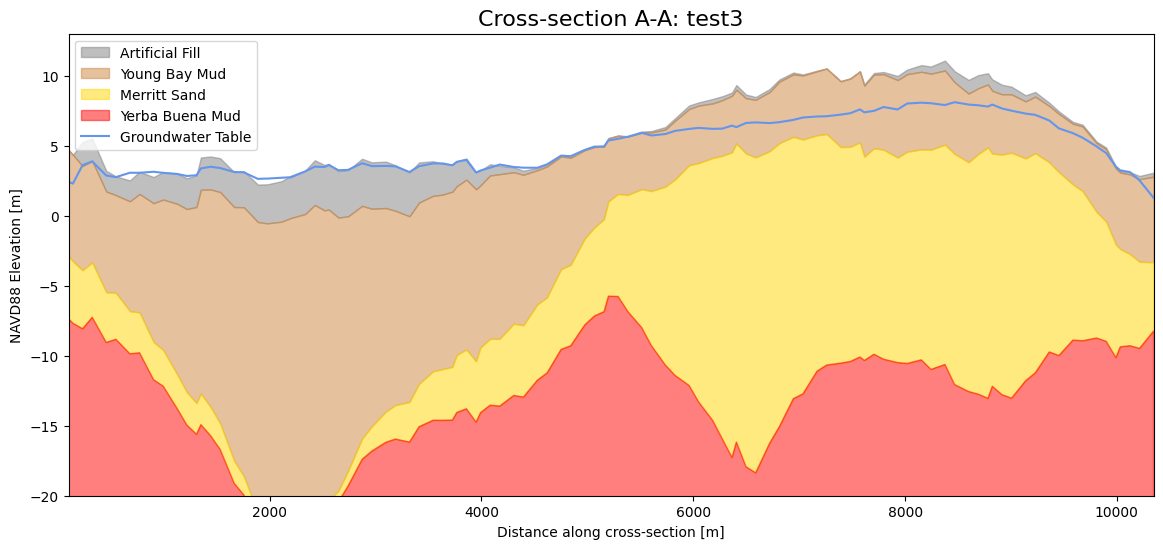

In [4]:
# Load the pre-existing points DataFrame
# points = setup_grid_no_crop()  # This should match the structure in setup_test.py
## assign elevation to points
elev_tif = './Alameda_elevation.tif'
points['Latitude'] = points['lat']
points['Longitude'] = points['lon']
points = assign_elevation(points,elev_tif)
# Convert lat/lon to UTM (assuming EPSG:4326 -> UTM Zone 10N)
points['UTM_X'], points['UTM_Y'] = zip(*points.apply(lambda row: utm.from_latlon(row['lat'], row['lon'])[:2], axis=1))

# Load thickness layers and groundwater table as rasterio datasets
layers = {
    "fill": rasterio.open("./out_geotiffs/layer0_thick_m_test3.tif"),
    "ybm": rasterio.open("./out_geotiffs/layer1_thick_m_test3.tif"),
    "ms": rasterio.open("./out_geotiffs/layer2_thick_m_test3.tif"),
    "ybmud": rasterio.open("./out_geotiffs/layer3_thick_m_test3.tif"),
    "wt_depth": rasterio.open("./wtdepths_250130/alameda_0_MHHW_slr0.00m_Khtest3_10m_wtdepth_nofel.tif")
}

# Extract values from raster at each point location
for layer_name, dataset in layers.items():
    # points[layer_name] = [v[0] for v in dataset.sample(zip(points['UTM_X'], points['UTM_Y']))]
    points[layer_name] = [np.nan if v[0] == -9999 else float(v[0]) for v in dataset.sample(zip(points['UTM_X'], points['UTM_Y']))]

# Define cross-section A-A
# LINESTRING (-122.33224638091333 37.796072669912924, -122.2256930020099 37.756765856297626
section_AA = LineString([(-122.33224638091333, 37.796072669912924), (-122.2256930020099, 37.756765856297626)])

# Compute distances along cross-section
points_gdf = gpd.GeoDataFrame(points, geometry=gpd.points_from_xy(points['lon'], points['lat']), crs="EPSG:4326")
points_gdf = points_gdf.to_crs("EPSG:32610")  # Convert to UTM for distance calculations
utm_coords = [utm.from_latlon(lat, lon)[:2] for lon, lat in section_AA.coords]
line_utm = LineString(utm_coords)

points_gdf['distance_to_line'] = points_gdf.geometry.apply(lambda point: point.distance(line_utm))

# Filter points near the section line
points_near_line = points_gdf[points_gdf['distance_to_line'] <= 50]  # Adjust threshold
points_near_line['distance_along_line'] = points_near_line.geometry.apply(lambda point: line_utm.project(point))
points_near_line = points_near_line.sort_values('distance_along_line')
points_near_line = points_near_line[['distance_along_line', 'elevation', 'fill', 'ybm', 'ms', 'ybmud','wt_depth']].dropna()

# Plot cross-section
plt.figure(figsize=(14, 6))
plt.fill_between(
    points_near_line['distance_along_line'],
    points_near_line['elevation'],
    points_near_line['elevation'] - points_near_line['fill'],
    color='grey', alpha=0.5, label='Artificial Fill'
)
plt.fill_between(
    points_near_line['distance_along_line'],
    points_near_line['elevation'] - points_near_line['fill'],
    points_near_line['elevation'] - points_near_line['fill'] - points_near_line['ybm'],
    color='peru', alpha=0.5, label='Young Bay Mud'
)
plt.fill_between(
    points_near_line['distance_along_line'],
    points_near_line['elevation'] - points_near_line['fill'] - points_near_line['ybm'],
    points_near_line['elevation'] - points_near_line['fill'] - points_near_line['ybm'] - points_near_line['ms'],
    color='gold', alpha=0.5, label='Merritt Sand'
)
plt.fill_between(
    points_near_line['distance_along_line'],
    points_near_line['elevation'] - points_near_line['fill'] - points_near_line['ybm'] - points_near_line['ms'],
    points_near_line['elevation'] - 50,
    color='red', alpha=0.5, label='Yerba Buena Mud'
)

# Plot groundwater table
plt.plot(
    points_near_line['distance_along_line'],
    points_near_line['elevation'] - points_near_line['wt_depth'],
    color='cornflowerblue', linestyle='-', label='Groundwater Table'
)

plt.title("Cross-section A-A: test3", fontsize=16)
plt.xlabel("Distance along cross-section [m]")
plt.ylabel("NAVD88 Elevation [m]")
plt.xlim(min(points_near_line['distance_along_line']), max(points_near_line['distance_along_line']))
plt.ylim(-20, 13)
plt.legend()
plt.show()


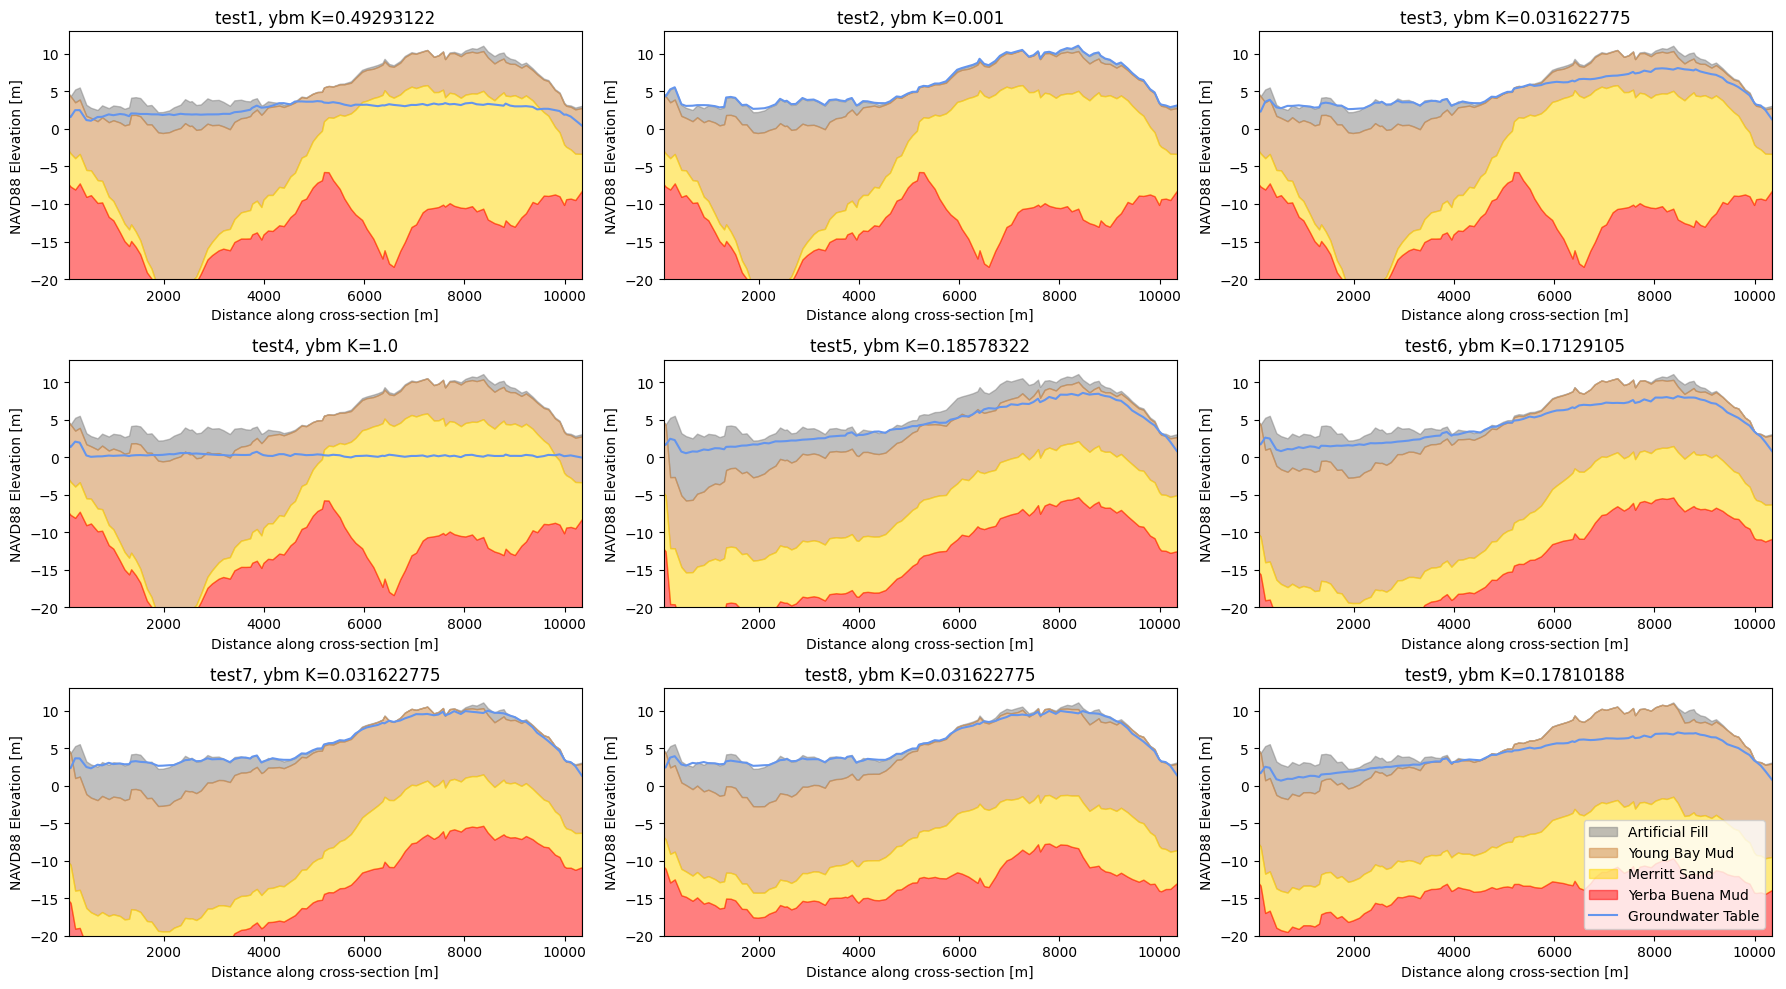

In [5]:
# make a plot with subplots as the above but 3x3 and each will be a different test (test1, test2, test3)
tests = ['test1', 'test2', 'test3', 'test4', 'test5', 'test6', 'test7', 'test8', 'test9']
fig, axs = plt.subplots(3, 3, figsize=(18, 10))
axes = axs.flatten()
for ind, test in enumerate(tests):
    # Load thickness layers and groundwater table as rasterio datasets
    layers = {
        "fill": rasterio.open(f"./out_geotiffs/layer0_thick_m_{test}.tif"),
        "ybm": rasterio.open(f"./out_geotiffs/layer1_thick_m_{test}.tif"),
        "ms": rasterio.open(f"./out_geotiffs/layer2_thick_m_{test}.tif"),
        "ybmud": rasterio.open(f"./out_geotiffs/layer3_thick_m_{test}.tif"),
        "wt_depth": rasterio.open(f"./wtdepths_250130/alameda_0_MHHW_slr0.00m_Kh{test}_10m_wtdepth_nofel.tif")
    }
    ybmk = rasterio.open(f"./out_geotiffs/layer1_hK_mday_{test}.tif")
    ybmk = ybmk.read(1)
    # print(np.log10(ybmk[0][0]))
    # Extract values from raster at each point location
    for layer_name, dataset in layers.items():
        # points[layer_name] = [v[0] for v in dataset.sample(zip(points['UTM_X'], points['UTM_Y']))]
        points[layer_name] = [np.nan if v[0] == -9999 else float(v[0]) for v in dataset.sample(zip(points['UTM_X'], points['UTM_Y']))]

    # Define cross-section A-A
    # LINESTRING (-122.33224638091333 37.796072669912924, -122.2256930020099 37.756765856297626
    section_AA = LineString([(-122.33224638091333, 37.796072669912924), (-122.2256930020099, 37.756765856297626)])

    # Compute distances along cross-section
    points_gdf = gpd.GeoDataFrame(points, geometry=gpd.points_from_xy(points['lon'], points['lat']), crs="EPSG:4326")
    points_gdf = points_gdf.to_crs("EPSG:32610")  # Convert to UTM for distance calculations
    utm_coords = [utm.from_latlon(lat, lon)[:2] for lon, lat in section_AA.coords]
    line_utm = LineString(utm_coords)

    points_gdf['distance_to_line'] = points_gdf.geometry.apply(lambda point: point.distance(line_utm))

    # Filter points near the section line
    points_near_line = points_gdf[points_gdf['distance_to_line'] <= 50]  # Adjust threshold
    points_near_line['distance_along_line'] = points_near_line.geometry.apply(lambda point: line_utm.project(point))
    points_near_line = points_near_line.sort_values('distance_along_line')
    points_near_line = points_near_line[['distance_along_line', 'elevation', 'fill', 'ybm', 'ms', 'ybmud','wt_depth']].dropna()

    # Plot cross-section
    ax = axes[ind]
    ax.fill_between(
        points_near_line['distance_along_line'],
        points_near_line['elevation'],
        points_near_line['elevation'] - points_near_line['fill'],
        color='grey', alpha=0.5, label='Artificial Fill'
    )
    ax.fill_between(
        points_near_line['distance_along_line'],
        points_near_line['elevation'] - points_near_line['fill'],
        points_near_line['elevation'] - points_near_line['fill'] - points_near_line['ybm'],
        color='peru', alpha=0.5, label='Young Bay Mud'
    )
    ax.fill_between(
        points_near_line['distance_along_line'],
        points_near_line['elevation'] - points_near_line['fill'] - points_near_line['ybm'],
        points_near_line['elevation'] - points_near_line['fill'] - points_near_line['ybm'] - points_near_line['ms'],
        color='gold', alpha=0.5, label='Merritt Sand'
    )
    ax.fill_between(
        points_near_line['distance_along_line'],
        points_near_line['elevation'] - points_near_line['fill'] - points_near_line['ybm'] - points_near_line['ms'],
        points_near_line['elevation'] - 50,
        color='red', alpha=0.5, label='Yerba Buena Mud'
    )

    # Plot groundwater table
    ax.plot(
        points_near_line['distance_along_line'],
        points_near_line['elevation'] - points_near_line['wt_depth'],
        color='cornflowerblue', linestyle='-', label='Groundwater Table'
    )

    ax.set_title(test +', ybm K='+ str(ybmk[0][0]), fontsize=12)
    ax.set_xlabel("Distance along cross-section [m]")
    ax.set_ylabel("NAVD88 Elevation [m]")
    ax.set_xlim(min(points_near_line['distance_along_line']), max(points_near_line['distance_along_line']))
    ax.set_ylim(-20, 13)
plt.legend()
plt.tight_layout()
plt.show()


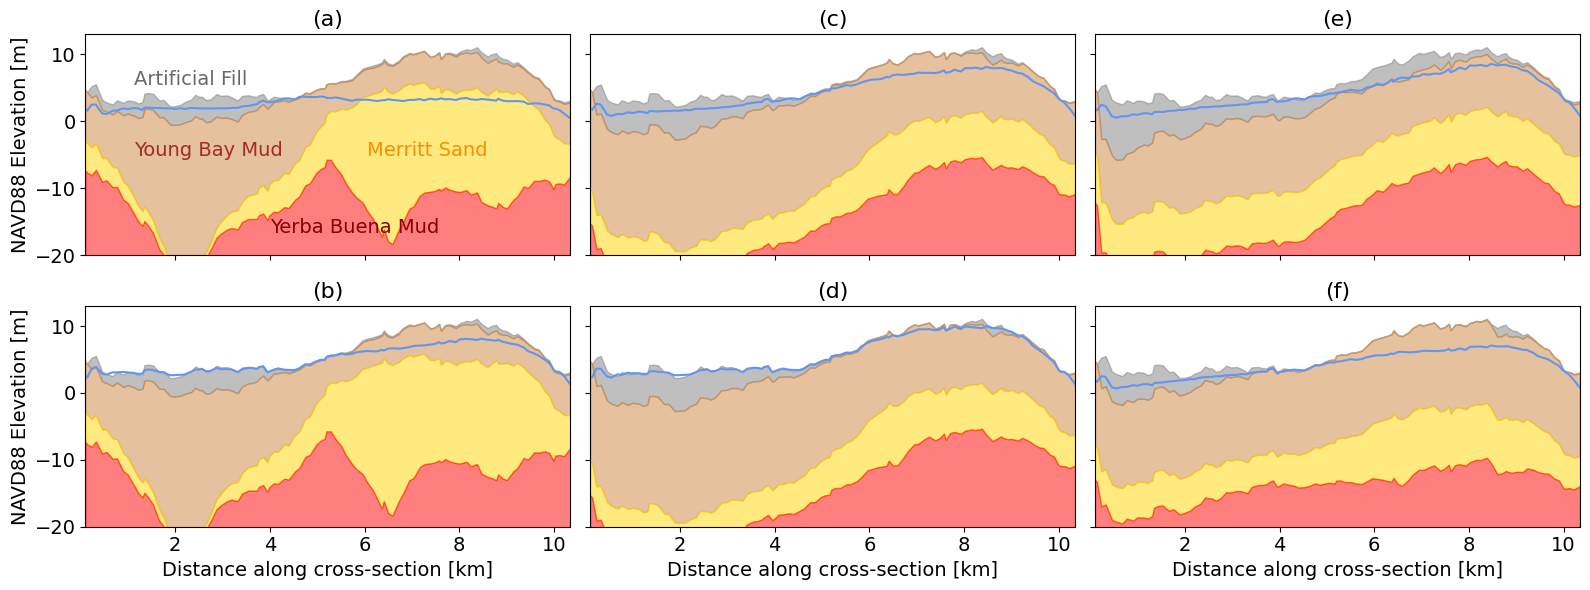

In [20]:
tests = ["test1", "test6", "test5", "test3", "test7", "test9"]
label = ['(a)', '(c)', '(e)', '(b)', '(d)', '(f)']
# make all tick labels font 14
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

fig, axs = plt.subplots(2, 3, figsize=(16, 6))
axes = axs.flatten()
for ind, test in enumerate(tests):
    # Load thickness layers and groundwater table as rasterio datasets
    layers = {
        "fill": rasterio.open(f"./out_geotiffs/layer0_thick_m_{test}.tif"),
        "ybm": rasterio.open(f"./out_geotiffs/layer1_thick_m_{test}.tif"),
        "ms": rasterio.open(f"./out_geotiffs/layer2_thick_m_{test}.tif"),
        "ybmud": rasterio.open(f"./out_geotiffs/layer3_thick_m_{test}.tif"),
        "wt_depth": rasterio.open(f"./wtdepths_250130/alameda_0_MHHW_slr0.00m_Kh{test}_10m_wtdepth_nofel.tif")
    }
    ybmk = rasterio.open(f"./out_geotiffs/layer1_hK_mday_{test}.tif")
    ybmk = ybmk.read(1)
    # print(np.log10(ybmk[0][0]))
    # Extract values from raster at each point location
    for layer_name, dataset in layers.items():
        # points[layer_name] = [v[0] for v in dataset.sample(zip(points['UTM_X'], points['UTM_Y']))]
        points[layer_name] = [np.nan if v[0] == -9999 else float(v[0]) for v in dataset.sample(zip(points['UTM_X'], points['UTM_Y']))]

    # Define cross-section A-A
    # LINESTRING (-122.33224638091333 37.796072669912924, -122.2256930020099 37.756765856297626
    section_AA = LineString([(-122.33224638091333, 37.796072669912924), (-122.2256930020099, 37.756765856297626)])

    # Compute distances along cross-section
    points_gdf = gpd.GeoDataFrame(points, geometry=gpd.points_from_xy(points['lon'], points['lat']), crs="EPSG:4326")
    points_gdf = points_gdf.to_crs("EPSG:32610")  # Convert to UTM for distance calculations
    utm_coords = [utm.from_latlon(lat, lon)[:2] for lon, lat in section_AA.coords]
    line_utm = LineString(utm_coords)
    
    points_gdf['distance_to_line'] = points_gdf.geometry.apply(lambda point: point.distance(line_utm))

    # Filter points near the section line
    points_near_line = points_gdf[points_gdf['distance_to_line'] <= 50]  # Adjust threshold
    points_near_line['distance_along_line'] = points_near_line.geometry.apply(lambda point: line_utm.project(point))
    points_near_line = points_near_line.sort_values('distance_along_line')
    points_near_line = points_near_line[['distance_along_line', 'elevation', 'fill', 'ybm', 'ms', 'ybmud','wt_depth']].dropna()

    # Plot cross-section
    ax = axes[ind]
    ax.fill_between(points_near_line['distance_along_line'],
        points_near_line['elevation'],
        points_near_line['elevation'] - points_near_line['fill'],
        color='grey', alpha=0.5, label='Artificial Fill')
    ax.fill_between(points_near_line['distance_along_line'],
        points_near_line['elevation'] - points_near_line['fill'],
        points_near_line['elevation'] - points_near_line['fill'] - points_near_line['ybm'],
        color='peru', alpha=0.5, label='Young Bay Mud')
    ax.fill_between(points_near_line['distance_along_line'],
        points_near_line['elevation'] - points_near_line['fill'] - points_near_line['ybm'],
        points_near_line['elevation'] - points_near_line['fill'] - points_near_line['ybm'] - points_near_line['ms'],
        color='gold', alpha=0.5, label='Merritt Sand')
    ax.fill_between(points_near_line['distance_along_line'],
        points_near_line['elevation'] - points_near_line['fill'] - points_near_line['ybm'] - points_near_line['ms'],
        points_near_line['elevation'] - 50,
        color='red', alpha=0.5, label='Yerba Buena Mud')

    # Plot groundwater table
    ax.plot(
        points_near_line['distance_along_line'],
        points_near_line['elevation'] - points_near_line['wt_depth'],
        color='cornflowerblue', linestyle='-', label='Groundwater Table'
    )

    ax.set_title(label[ind], fontsize=16)
    # if ind.isin([0, 3]): does not work but make the same functionality
    if ind in [0, 3]:
        ax.set_ylabel("NAVD88 Elevation [m]", fontsize=14)
    else:
        ax.set_yticklabels([])
    if ind in [3, 4, 5]:
        ax.set_xlabel("Distance along cross-section [km]", fontsize=14)
        ax.set_xticklabels([f"{int(x/1000)}" for x in ax.get_xticks()[1:]])
    else:
        ax.set_xticklabels([])
    ax.set_xlim(min(points_near_line['distance_along_line']), max(points_near_line['distance_along_line']))
    ax.set_ylim(-20, 13)
# plt.legend()
    # add labels to the first subplot as text on the figure
    if ind == 0:
        ax.text(0.1, 0.77, 'Artificial Fill', color='dimgrey', transform=ax.transAxes, fontsize=14)
        ax.text(0.1, 0.45, 'Young Bay Mud', color='brown', transform=ax.transAxes, fontsize=14)
        ax.text(0.58, 0.45, 'Merritt Sand', color='darkorange', transform=ax.transAxes, fontsize=14)
        ax.text(0.38, 0.1, 'Yerba Buena Mud', color='darkred', transform=ax.transAxes, fontsize=14)
plt.tight_layout()

plt.savefig('./figures/test_cross_sections.png',dpi=1000, bbox_inches='tight',format='png')
plt.savefig('./figures/test_cross_sections.pdf',dpi=1000, bbox_inches='tight',format='pdf')
plt.show()


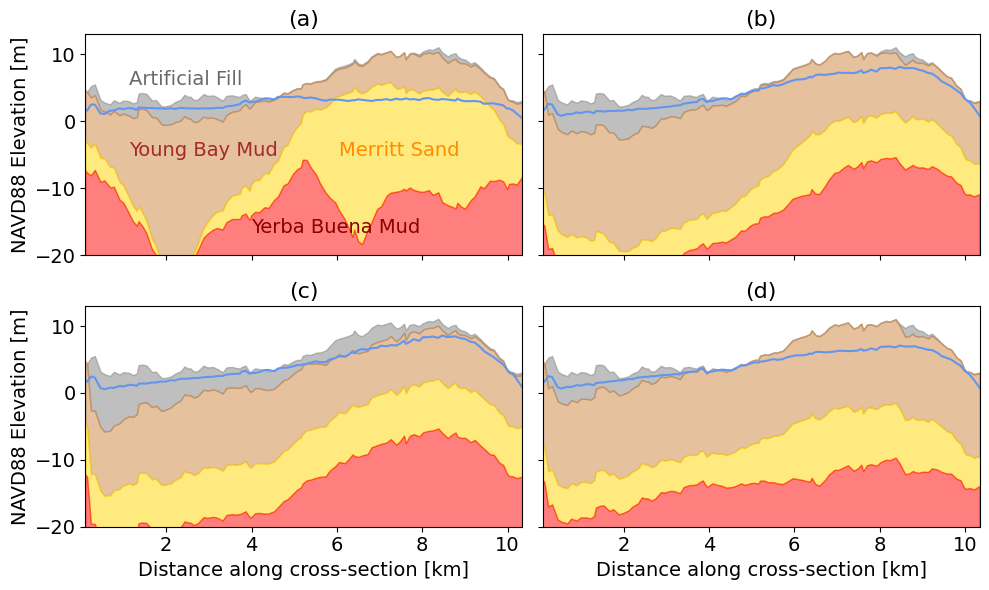

In [8]:
tests = ["test1", "test6", "test5", "test9"]
label = ['(a)', '(b)', '(c)', '(d)']
# make all tick labels font 14
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

fig, axs = plt.subplots(2, 2, figsize=(10, 6))
axes = axs.flatten()
for ind, test in enumerate(tests):
    # Load thickness layers and groundwater table as rasterio datasets
    layers = {
        "fill": rasterio.open(f"./out_geotiffs/layer0_thick_m_{test}.tif"),
        "ybm": rasterio.open(f"./out_geotiffs/layer1_thick_m_{test}.tif"),
        "ms": rasterio.open(f"./out_geotiffs/layer2_thick_m_{test}.tif"),
        "ybmud": rasterio.open(f"./out_geotiffs/layer3_thick_m_{test}.tif"),
        "wt_depth": rasterio.open(f"./wtdepths_250130/MTL/alameda_0_MTL_slr0.00m_Kh{test}_10m_wtdepth_nofel.tif")
    }
    ybmk = rasterio.open(f"./out_geotiffs/layer1_hK_mday_{test}.tif")
    ybmk = ybmk.read(1)
    # print(np.log10(ybmk[0][0]))
    # Extract values from raster at each point location
    for layer_name, dataset in layers.items():
        # points[layer_name] = [v[0] for v in dataset.sample(zip(points['UTM_X'], points['UTM_Y']))]
        points[layer_name] = [np.nan if v[0] == -9999 else float(v[0]) for v in dataset.sample(zip(points['UTM_X'], points['UTM_Y']))]

    # Define cross-section A-A
    # LINESTRING (-122.33224638091333 37.796072669912924, -122.2256930020099 37.756765856297626
    section_AA = LineString([(-122.33224638091333, 37.796072669912924), (-122.2256930020099, 37.756765856297626)])

    # Compute distances along cross-section
    points_gdf = gpd.GeoDataFrame(points, geometry=gpd.points_from_xy(points['lon'], points['lat']), crs="EPSG:4326")
    points_gdf = points_gdf.to_crs("EPSG:32610")  # Convert to UTM for distance calculations
    utm_coords = [utm.from_latlon(lat, lon)[:2] for lon, lat in section_AA.coords]
    line_utm = LineString(utm_coords)
    
    points_gdf['distance_to_line'] = points_gdf.geometry.apply(lambda point: point.distance(line_utm))

    # Filter points near the section line
    points_near_line = points_gdf[points_gdf['distance_to_line'] <= 50]  # Adjust threshold
    points_near_line['distance_along_line'] = points_near_line.geometry.apply(lambda point: line_utm.project(point))
    points_near_line = points_near_line.sort_values('distance_along_line')
    points_near_line = points_near_line[['distance_along_line', 'elevation', 'fill', 'ybm', 'ms', 'ybmud','wt_depth']].dropna()

    # Plot cross-section
    ax = axes[ind]
    ax.fill_between(points_near_line['distance_along_line'],
        points_near_line['elevation'],
        points_near_line['elevation'] - points_near_line['fill'],
        color='grey', alpha=0.5, label='Artificial Fill')
    ax.fill_between(points_near_line['distance_along_line'],
        points_near_line['elevation'] - points_near_line['fill'],
        points_near_line['elevation'] - points_near_line['fill'] - points_near_line['ybm'],
        color='peru', alpha=0.5, label='Young Bay Mud')
    ax.fill_between(points_near_line['distance_along_line'],
        points_near_line['elevation'] - points_near_line['fill'] - points_near_line['ybm'],
        points_near_line['elevation'] - points_near_line['fill'] - points_near_line['ybm'] - points_near_line['ms'],
        color='gold', alpha=0.5, label='Merritt Sand')
    ax.fill_between(points_near_line['distance_along_line'],
        points_near_line['elevation'] - points_near_line['fill'] - points_near_line['ybm'] - points_near_line['ms'],
        points_near_line['elevation'] - 50,
        color='red', alpha=0.5, label='Yerba Buena Mud')

    # Plot groundwater table
    ax.plot(
        points_near_line['distance_along_line'],
        points_near_line['elevation'] - points_near_line['wt_depth'],
        color='cornflowerblue', linestyle='-', label='Groundwater Table'
    )

    ax.set_title(label[ind], fontsize=16)
    # if ind.isin([0, 3]): does not work but make the same functionality
    if ind in [0, 2]:
        ax.set_ylabel("NAVD88 Elevation [m]", fontsize=14)
    else:
        ax.set_yticklabels([])
    if ind in [2, 3]:
        ax.set_xlabel("Distance along cross-section [km]", fontsize=14)
        ax.set_xticklabels([f"{int(x/1000)}" for x in ax.get_xticks()[1:]])
    else:
        ax.set_xticklabels([])
    ax.set_xlim(min(points_near_line['distance_along_line']), max(points_near_line['distance_along_line']))
    ax.set_ylim(-20, 13)
# plt.legend()
    # add labels to the first subplot as text on the figure
    if ind == 0:
        ax.text(0.1, 0.77, 'Artificial Fill', color='dimgrey', transform=ax.transAxes, fontsize=14)
        ax.text(0.1, 0.45, 'Young Bay Mud', color='brown', transform=ax.transAxes, fontsize=14)
        ax.text(0.58, 0.45, 'Merritt Sand', color='darkorange', transform=ax.transAxes, fontsize=14)
        ax.text(0.38, 0.1, 'Yerba Buena Mud', color='darkred', transform=ax.transAxes, fontsize=14)
plt.tight_layout()

plt.savefig('./figures/test_cross_sections_MTL.png',dpi=1000, bbox_inches='tight',format='png')
plt.savefig('./figures/test_cross_sections_MTL.pdf',dpi=1000, bbox_inches='tight',format='pdf')
plt.show()


In [11]:
## close all the files i opened
for layer_name, dataset in layers.items():
    dataset.close()